In [3]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
#on installe les librairies necessaires pour le TP
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']

c:\Users\ks_bo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# le dataset contient beaucoup de fillers dont on connait pas l'output donc on va les supprimer
data = np.load('twri_rgb_6832_cotton_64x64_9_02.npy')
labels = pd.read_csv('labels_rgb (2).csv')
y_label = labels['class'].values

new_data_without_filler = np.zeros((5376, 64, 64, 3))
new_y_label_without_filler = np.zeros(5376, dtype=int)
i = 0
for idx, val in enumerate(y_label):
  if val != 0:
    new_data_without_filler[i] = data[idx]
    new_y_label_without_filler[i] = y_label[idx]
    i+=1
data = new_data_without_filler
y_label = new_y_label_without_filler - 1
# Maintenant on a data qui contient toutes les images ainsi que y_label correspandants

In [5]:
data.shape

(5376, 64, 64, 3)

In [6]:
y_label.shape

(5376,)

On remarque donc que les labels et notre data sont coherents ( meme taille apres suppression des fillers )

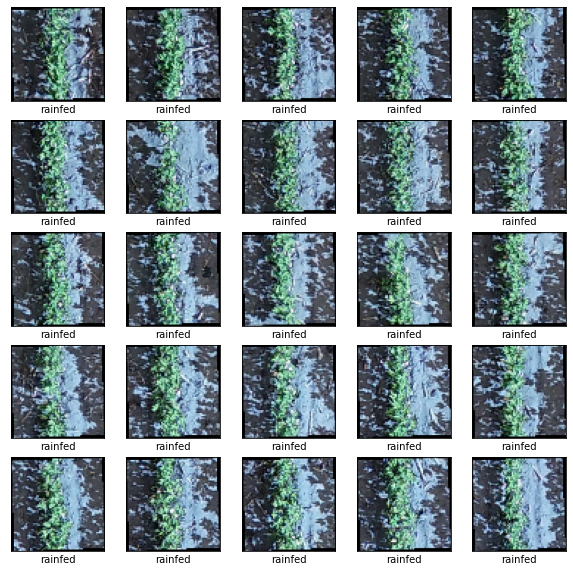

In [7]:
# On visualise les 25 premieres images du dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i]/255)
    plt.xlabel(class_names[y_label[i]])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# on divise nos données en : 70% pour entrainer le modele / 30% pour tester le modele
train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=0.3)

# on Normalise the images vers l'intervalle [0, 1] pour aider le modele plus tard à converger rapidement
train_images = train_images / 255.0
test_images = test_images / 255.0

# Verification des formats des données
print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training data shape: (3763, 64, 64, 3)
Training labels shape: (3763,)
Test data shape: (1613, 64, 64, 3)
Test labels shape: (1613,)


On a donc 3763 images en matrice 64*64 pixels et chaque pixel est un vecteur de 3 dimensions representant le R,G,B

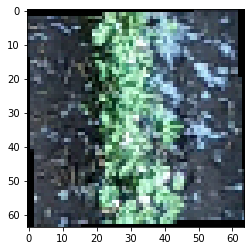

In [16]:
image = train_images[0]
plt.imshow(image)

In [8]:
train_labels[0]

2

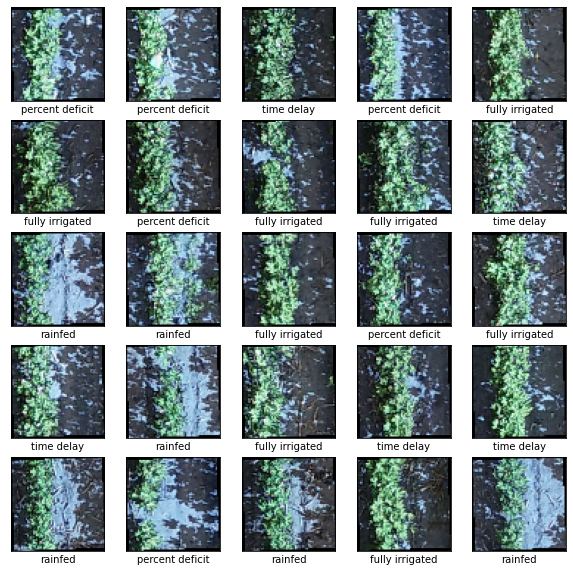

In [9]:
#Il faut s'assurer que les données sont maintenant aléatoires et pretes pour l'entrainement
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Effectivement on remarque que contrairement aux images affichées au début les données sont maintenant aleatoires et de classes différentes

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [13]:
#On commence à entrainer le modele
model = models.Sequential()

In [14]:
#couche d'entrée et première couche de convolution
# applique 32 filtres de convolution de taille 3x3 sur les images d'entrée
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
#Première couche de pooling qui va réduire la dimensionnalité de l'entrée
model.add(layers.MaxPooling2D((2, 2)))
#On refait le meme truc 2 fois
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#Aplatie la sortie 3D de la couche de convolution précédente en un vecteur 1D, prêt pour les couches entièrement connectées ( couches denses )
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#Couche de sortie avec 4 neurones (correspondant aux 4 classes de classification)
model.add(layers.Dense(4))

c:\Users\ks_bo\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,468 (2.47 MB)

 Trainable params: 646,468 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#On compile le modele avec l'optimiseur adam et la fonction de perte SparseCategoricalCrossentropy utilisée pour les classification multi-classes
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']) # Évalue les performances du modèle avec la métrique d'accuracy, indiquant le pourcentage de prédictions correctes

In [17]:
history = model.fit(
    train_images,  # Données d'entraînement (images)
    train_labels,  # labels des données d'entraînement
    epochs=70,  # Nombre d'époques d'entraînement
    validation_data=(test_images, test_labels)  # Données de validation (images et étiquettes)
)

Epoch 1/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4038 - loss: 1.2245 - val_accuracy: 0.5840 - val_loss: 0.9056
Epoch 2/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6529 - loss: 0.7963 - val_accuracy: 0.6993 - val_loss: 0.6887
Epoch 3/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7078 - loss: 0.6746 - val_accuracy: 0.6975 - val_loss: 0.6653
Epoch 4/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7411 - loss: 0.6125 - val_accuracy: 0.7681 - val_loss: 0.5487
Epoch 5/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7960 - loss: 0.5106 - val_accuracy: 0.7390 - val_loss: 0.6515
Epoch 6/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8041 - loss: 0.4960 - val_accuracy: 0.7855 - val_loss: 0.5075
Epoch 7/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8237 - loss: 0.4495 - val_accuracy: 0.7663 - val_loss: 0.5476
Epoch 8/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8293 - loss: 0.4311 - val_accu

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

c:\Users\ks_bo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
predictions = np.argmax(model.predict(test_images), axis=-1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [20]:
#On cree la matrice de confusion
cm = confusion_matrix(test_labels, predictions)

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

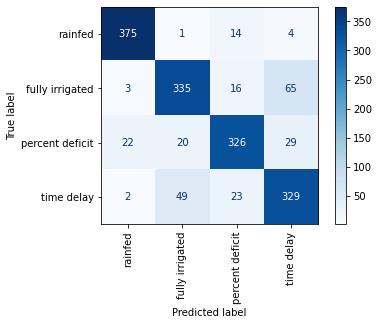

In [22]:
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')

On va calculer les différentes métriques pour évaluer le modele

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [24]:
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8462492250464972


In [25]:
precision = precision_score(test_labels, predictions, average='macro')
print(f"Precision: {precision}")

Precision: 0.8476616073367544


In [26]:
recall = recall_score(test_labels, predictions, average='macro')
print(f"Recall: {recall}")

Recall: 0.8472087960423555


In [27]:
f1_score = f1_score(test_labels, predictions, average='macro')
print(f"F1 Score: {f1_score}")

F1 Score: 0.8470737803243116


Les résultats obtenus montrent que le modèle de réseau de neurones convolutif (CNN) présente de bonnes performances globales sur l'ensemble de données de test. Plus précisément, le modèle a atteint une précision de 82,52%, ce qui signifie que 82,52% des prédictions étaient correctes. La précision de 82,69% indique que parmi les prédictions faites pour une classe donnée, 82,69% étaient effectivement correctes. Le rappel de 82,88% révèle que le modèle a correctement identifié 82,88% des instances réelles de chaque classe. Enfin, le F1 score, qui est la moyenne harmonique de la précision et du rappel, est de 82,78%, soulignant un bon équilibre entre les faux positifs et les faux négatifs. Ces métriques suggèrent que le modèle est bien capable de généraliser et de fournir des prédictions fiables sur des données non vues. 